In [3]:
from ModelClass import RegressionModel
from DatasetClass import Dataset, DatasetMass
import matplotlib.pyplot as plt
import numpy as np
import itertools
from src.helpers import make_filter_slice
import tensorflow as tf
import optuna 
from optuna_dashboard import run_server
import threading
#import sys
#import logging 


2025-03-25 01:00:24.893613: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-25 01:00:24.903230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742860824.915430 2123448 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742860824.919100 2123448 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-25 01:00:24.932859: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
erik_data = "/scratch/ucjf-atlas/htautau/SM_Htautau_R22/V02_skim_mva_01/*/*/*/*/*H125*.root"
patrik_data = "/scratch/ucjf-atlas/htautau/SM_Htautau_R22/V02_skim_mva_01/*/*/*/*/*Ztt*.root"


I0000 00:00:1742860832.998950 2123448 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43493 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:41:00.0, compute capability: 8.9


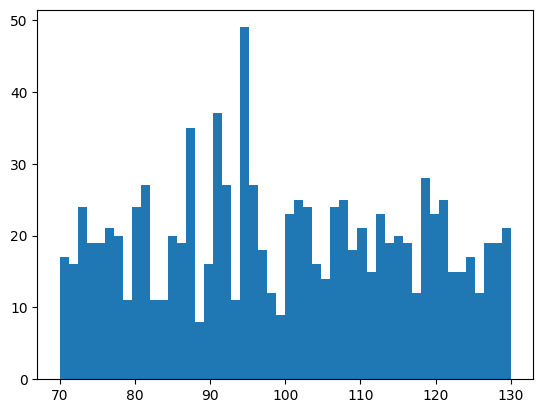

In [5]:

dataset = DatasetMass(file_paths=patrik_data, file_name = "data")
dataset.load_data()
dataset.augment_data_phi(n_slices=10)
#start_time = time.time()
#for batch in dataset.train_dataset.take(1):
#    print("Batch loaded in:", time.time() - start_time)
#train_batches = dataset.train_dataset.batch(32)
#for feature, target in train_batches.take(1):
#    print(f"Feature: {feature.shape}")
#    print(f"Target: {target.shape}")

#print(len(dataset.train_dataset))
#print(len(dataset.dev_dataset))
#print(len(dataset.val_dataset))
#This block of code iterates through the dataset and extracts the pt values of the labels and stores them in a list
#data = [labels.numpy()[0] for features, labels in dataset.train_dataset.take(100000)]

#plt.hist(data, bins=100, range=(50, 130), histtype='step', label='pt distribution', density=False)
#plt.legend(loc='upper right')
#plt.title('pt distribution of the dataset')
#plt.xlabel('pt')
#plt.ylabel('Number of events')
#plt.show()


features, masses = next(iter(dataset.train_dataset.batch(1000)))

#print(features.shape)
#print(features)

plt.hist(masses, range=(70, 130), bins=50)
plt.show()



In [5]:
for sample in dataset.train_dataset.take(1):
    print(sample)


(<tf.Tensor: shape=(35,), dtype=float32, numpy=
array([ 7.9698662e+01,  6.1323375e-01, -8.7493402e-01,  0.0000000e+00,
        3.8777607e+01,  3.8384306e-01, -1.8669480e+00, -4.7683716e-07,
        2.2939068e-01,  1.9694054e+00,  2.0282004e+00,  7.6542953e+01,
        1.1847627e+02,  1.0869468e+02, -5.2226692e-01,  2.9164805e+00,
        2.2685047e+01,  6.0651863e+01,  1.3404112e+00, -3.1856185e-01,
        6.9703789e+00,  7.5218994e+01,  6.0732043e-01,  2.0889819e+00,
        2.3333194e+02,  2.3549999e+01,  0.0000000e+00,  6.1772847e-01,
       -1.6468724e-03,  2.0000000e+00,  2.0000000e+00,  2.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  2.0000000e+00], dtype=float32)>, <tf.Tensor: shape=(), dtype=float32, numpy=118.97869873046875>)


2025-03-24 21:34:11.876591: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


I0000 00:00:1742848633.867110 2916524 service.cc:148] XLA service 0x7f5138046140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742848633.867159 2916524 service.cc:156]   StreamExecutor device (0): NVIDIA L40, Compute Capability 8.9
2025-03-24 21:37:13.894024: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742848633.986289 2916524 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1742848634.878876 2916524 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [5]:
dataset.make_slices(n_slices=100)
slices = dataset.slices   

lorentz_mask = tf.constant(dataset.get_lorentz_mask())  # Shape [35] bool values
lorentz_indices = tf.squeeze(tf.where(lorentz_mask), axis=1) # [0 1 2 3 4 5 6 7 13 14 ...] 
n_vectors = tf.shape(lorentz_indices)[0] // 4 # number of 4-vectors
lorentz_indices_4d = tf.reshape(lorentz_indices, (n_vectors, 4))  # [n_vectors, 4]

@tf.function
def augment_lorentz(data, target):
    beta = tf.random.uniform(shape = (), minval=-0.98, maxval=0.98) # Shape ()
    #tf.print("used beta: ", beta)
    gamma = 1.0 / tf.sqrt(1.0 - beta**2) # Shape ()
    #tf.print("used gamma: ", gamma)
    
    for i in range(n_vectors):
        vec_indices = lorentz_indices_4d[i] # Shape (4,)
        pt = data[vec_indices[0]] # scalar values
        eta = data[vec_indices[1]]
        #tf.print("eta: ", eta)
        phi = data[vec_indices[2]]
        E = data[vec_indices[3]]
        #tf.print("E: ", E)
        #print(E.shape)
        
        # Convert to Cartesian coordinates
        #px = pt * tf.cos(phi)
        #py = pt * tf.sin(phi)
        pz = pt * tf.sinh(eta) # Shape ()
        #tf.print("pz: ", pz)

        E_prime = gamma * (E - beta * pz) # Shape ()
        #tf.print("E_prime: ", E_prime)
        pz_prime = gamma * (pz - beta * E) 
        
        epsilon = 1e-8
        eta_prime = tf.asinh(pz_prime / (pt + epsilon)) # Shape ()
        #tf.print("eta_prime: ", eta_prime)
        update_indices = tf.reshape(vec_indices, [-1, 1])  # Shape (4, 1)
        update_values = tf.stack([pt, eta_prime, phi, E_prime]) # Shape (4,)
        # Update the tensor
        data = tf.tensor_scatter_nd_update(
            data,
            indices=update_indices,
            updates=update_values
        )
        #print(data.shape)
        
    return data, target

n_events = 10000
new_dataset = tf.data.Dataset.sample_from_datasets([s.repeat() for s in slices], weights=[1.]*len(slices))
#orig_features, orig_masses = next(iter(new_dataset))
#print(orig_features)
#print(orig_masses)
new_dataset = new_dataset.take(n_events)
augmented_dataset = new_dataset.map(augment_lorentz)
#new_features, new_masses = next(iter(new_dataset))
#print(new_features)š
#print(new_masses)
#batch_dataset = augmented_dataset.batch(n_events)
#print(f"Number of events in batch_dataset: {len(augmented_dataset)}")
#features, masses = next(iter(batch_dataset))

#plt.hist(masses, range=(70, 130), bins=50)
#plt.show()

                                                                    

In [ ]:

lorentz_mask = tf.constant(dataset.get_lorentz_mask()) 
print(lorentz_mask)

features = tf.constant([
    5.56329613e+01, -3.16469967e-01, -9.03481603e-01, 6.74349565e-07,
    5.47039528e+01, -1.49002433e-01, 2.52283901e-01, 1.05658375e-01,
    1.67467535e-01, 1.15576553e+00, 1.16783524e+00, 1.38526611e+02,
    1.10336914e+02, 1.38102692e+02, 1.74350947e-01, 2.87319326e+00,
    1.55200872e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
    0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
    0.00000000e+00, 4.71827660e+01, 0.00000000e+00, -6.81111366e-02,
    -1.58858541e-02, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
    0.00000000e+00, 1.00000000e+00, 1.00000000e+00
], dtype=tf.float32)

label = tf.constant(94.92591, dtype=tf.float32)

dataset = tf.data.Dataset.from_tensors((features, label))
dataset = dataset.map(augment_lorentz)

new_features, new_label = next(iter(dataset))
print(new_features)
print(new_label)

In [ ]:
dataset.make_slices(n_slices=10)
slices = dataset.slices 
phi_mask = tf.constant(dataset.get_phi_mask())

@tf.function
def augment_phi(data, target):
    # generate random rotation angle
    angle = tf.random.uniform(shape=(tf.shape(data)[0],), minval=-np.pi, maxval=np.pi)
    #tf.print("angle: ", angle.shape)
    #tf.print("data: ", data.shape)
    # apply rotation
    data  = tf.where(phi_mask, data + angle, data)
    
    # normalize angles between -pi and pi
    data = tf.where(phi_mask, tf.math.atan2(tf.sin(data), tf.cos(data)), data)
    
    return data, target

# sample from the slices
n_events = 1000
new_dataset = tf.data.Dataset.sample_from_datasets([s.repeat() for s in slices], weights=[1.]*len(slices))
new_dataset = new_dataset.take(n_events)

# apply augmentation
new_dataset = new_dataset.map(augment_phi)
#aug_dataset = new_dataset.batch(n_events)


#print(f"Number of events in batch_dataset: {len(batch_dataset)}")
#features, masses = next(iter(batch_dataset))
#print(features.shape)
#print(features)

#plt.hist(masses, range=(70, 130), bins=50)
#plt.show()




In [ ]:
param_grid = {
    'batch_size': [3200, 6400],
    'learning_rate': [0.01, 0.1],
    'epochs': [5, 20, 30]
}

iterable = list(itertools.product(*param_grid.values()))
for params in iterable:
    model = RegressionModel(dataset=dataset, batch_size=params[0], initial_learning_rate=params[1], n_epochs=params[2])
    model.prepare_dataset()
    model.create_normalizer()
    model.build_model()
    model.train_model()
    model.plot_history()

In [6]:
def objective(trial):

    model = RegressionModel(
                dataset,
                n_layers             = trial.suggest_int('n_layers', 1, 3),
                hidden_layer_size    = trial.suggest_int('hidden_layer_size', 32, 128, step=24),
                initial_learning_rate= trial.suggest_float('initial_learning_rate', 1e-3, 1e-2, log=True),
                n_epochs             = trial.suggest_int('n_epochs', 10, 20, step=5),
                activation_function  = 'relu',
                batch_size           = trial.suggest_int('batch_size', 512, 1024,step=64),
                dropout_rate         = trial.suggest_float('dropout_rate', 0.1, 0.5),
                weight_decay         = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)

            )

    model.prepare_dataset()
    model.create_normalizer()
    model.build_model()
    model.train_model()

    # Handle based on the number of metrics
    evaluation_results = model.model.evaluate(model.dev_batch, verbose=0)
    if isinstance(evaluation_results, list):
        val_loss = evaluation_results[0]
    else:
        val_loss = evaluation_results  # If only one value is returned, it's the loss

    return val_loss

study = optuna.create_study(storage="sqlite:///optuna.db", study_name="Higgs_analysis_mass_2", direction='minimize', load_if_exists=True)

def run_dashboard():
    server = run_server("sqlite:///optuna.db", host="0.0.0.0", port=8080)
    server.run()  # Run dashboard continuously in a separate thread

dashboard_thread = threading.Thread(target=run_dashboard)
dashboard_thread.daemon = True  # Ensures it stops when the script ends
dashboard_thread.start()

def run_optuna():
    study.optimize(objective, n_trials=100, n_jobs=1)

# Run Optuna in a separate thread so the dashboard can be accessed in real-time
optuna_thread = threading.Thread(target=run_optuna)
optuna_thread.start()

optuna_thread.join()  # Wait for Optuna to finish before printing results
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)



[I 2025-03-25 01:00:42,100] Using an existing study with name 'Higgs_analysis_mass_2' instead of creating a new one.
Bottle v0.13.2 server starting up (using WSGIRefServer())...
Listening on http://0.0.0.0:8080/
Hit Ctrl-C to quit.



Batching datasets...


2025-03-25 01:00:42.807776: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Building model...
Epoch 1/15


I0000 00:00:1742860845.551306 2123576 service.cc:148] XLA service 0x7f12140093a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742860845.551338 2123576 service.cc:156]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9
2025-03-25 01:00:45.576787: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742860845.668168 2123576 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/7616 ━━━━━━━━━━━━━━━━━━━━ 6:32:46 3s/step - loss: 10304.5186 - mean_absolute_percentage_error: 100.4438 - mean_squared_error: 10304.5186

I0000 00:00:1742860846.245512 2123576 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  23/7616 ━━━━━━━━━━━━━━━━━━━━ 3:02:10 1s/step - loss: 10201.1641 - mean_absolute_percentage_error: 99.5307 - mean_squared_error: 10201.1641

KeyboardInterrupt: 

  27/7616 ━━━━━━━━━━━━━━━━━━━━ 3:01:54 1s/step - loss: 10172.4043 - mean_absolute_percentage_error: 99.3647 - mean_squared_error: 10172.4043